# Column modeling to validate the Pe correlation

FITC-lysozyme dilute breakthrough on SP Sepharose FF, 2.0 ml column, 0.5 cm ID, on the Akta Explorer

Breakthrough data for 4% B, pH 9.5

2021-07-28

In [1]:
%load_ext autoreload
%autoreload 2
from analysis_functions.cadet_imports import * 


In [2]:
import analysis_functions.plot_chromatogram as my_plot
import analysis_functions.exploration_helper as my_help
import analysis_functions.my_cadet_utils as cadet_utils

from scipy import integrate, optimize
import multiprocessing as mp
from scipy.signal import savgol_filter

In [3]:
# Dp, eps_p, eps_c = (4.3e-11, 0.8421529231673788, 0.34456262415678807)

# Keq=Keq      # Single value estimated for best fit of all runs (previously estimated with differential evolution - try least squares as well - this is my task)
# Ds=Ds

# c_load=c_load             # Should get from extinction coefficient and breakthrough abs
# Dax=Dax                   # Varies with the flow rate - use get_Dax(flow)
# Dp=Dp                     # 4.3e-11
# eps_c=eps_c               # 0.34456262415678807
# eps_p=eps_p               # 0.8421529231673788
# data_df=my_data[f].df     # Need to look at residual function to determine what attributes of the df are used
# flow=flow                 # Need to check units 

## To do:
- [x] Estimate label ratio from A280:A495 from re-fractionation data
    - [x] Use linear interpolation to get concentration profiles on the same x axis
- [x] Get extinction coefficients for FITC-lysozyme and the mAb
    - [x] FITC-lysozyme:  use extinction coefficient for FITC at 495 nm with F/P ratio
    - [x] mAb 2:  from Soumi
- [x] Extract FITC-lysozyme and mAb concentrations from A280 and A495
    - [x] Apply a smoothing function for FITC-lysozyme concentrations (?)
- [x] Validate input parameters by simulating the mAb breakthrough
    - Need to fit Dp and eps_p
        - Could also use the mAb 2 flow-through control
- [x] Estimate best overall fit for Keq and Ds for the FITC-lysozyme
    - (This is at only one ionic strength, so Keq and Ds should be the same for all data sets)

# Load data

In [4]:
directory = './data/'
files = os.listdir(directory)
files.sort()

files_dic = {}
for i, f in enumerate(files):
    files_dic[i] = f
    
for key, value in files_dic.items():
    print(f'{key}: \t {value}')

0: 	 CH 2021 07 14 FITC Lysozyme conjugate purification.xls
1: 	 CH 2021 07 15 FITC Lysozyme pH 8p5 refractionation.xls
2: 	 CH 2021 07 15 FITC Lysozyme refrac A9 scout.xls
3: 	 CH 2021 07 15 Flowthrough controls FITC  Lysozyme pH 9p5.xls
4: 	 CH 2021 07 15 Flowthrough controls mAb 2 pH 9p5.xls
5: 	 CH 2021 07 15 Flowthrough controls mAb D pH 9p5.xls
6: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 1.xls
7: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 2.xls
8: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 3.xls
9: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 4.xls
10: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 5.xls


In [5]:
data_break = {}

for f in files:
    data_break[f] = my_plot.data(directory, f)

In [6]:
for f in files:
    if f == 'CH 2021 07 14 FITC Lysozyme conjugate purification.xls':
        data_break[f].v_col = 12.0
    else:
        data_break[f].v_col = 2.0
        
    for col_name in data_break[f].df.columns:
        if 'ml' in col_name and '/' not in col_name:
            data_break[f].df[col_name[:-3] + '_cv'] = data_break[f].df[col_name]/data_break[f].v_col
        if 'Temp_°C' == col_name:
            data_break[f].df = data_break[f].df.rename(columns={col_name: 'Temp_C'})
    
    for col_name in data_break[f].df.columns:
        if 'UV' in col_name:
            data_break[f].df = data_break[f].df.rename(columns={col_name: 'UV'+col_name[3:]})

# Label ratio estimation

In [7]:
# Extinction coefficient data
extinction_lys_280 = 37970 # M-1 cm-1
extinction_fluor = 68000
cf = 0.3

In [8]:
# Select the appropriate data frame
i = 1
file = files_dic[i]
image_name = file[:file.find('.xls')]
df = data_break[file].df

In [9]:
# Interpolation to get 495 nm absorbance on the same volume axis as 280 nm 
x = df.UV_280nm_cv.astype('float64')
xp = df.UV_495nm_cv.astype('float64')
yp = df.UV_495nm_mAU.astype('float64')
df['UV_495_mAU_for_280_cv'] = np.interp(x, xp, yp)

# Calculation of lysozyme concentration and F/P ratio
df['c_280_M'] = (df.UV_280nm_mAU - cf*df.UV_495_mAU_for_280_cv)/(1000 * extinction_lys_280)
df['fp_280']  = df.UV_495_mAU_for_280_cv/(1000 * extinction_fluor * df.c_280_M)

# How to compute FITC-lysozyme concentration from A495 given the F/P ratio
df['c_280_M_check'] = df.UV_495_mAU_for_280_cv/(1000 * extinction_fluor * df.fp_280)



In [10]:
# Rough approximation for the fraction of starting material - seems reasonable
start_mol = 50/1000/14300
mol_lys = integrate.trapz(y=df.c_280_M, x=df.UV_280nm_ml/1000)
mol_lys/start_mol 

0.11634045932162407

In [11]:
# Select the material that was pooled for use in the Pe correlation validation
# in order to estimate the average F/P
# Note only ~70% of sample A9 was actually used
# Below is the naive estimate

frac_times = [x for x in df['Fractions_cv'] if str(x) != 'nan']
frac_names = [x for x in df['Fractions_(Fractions)'] if str(x) != 'nan']
for (time, name) in zip(frac_times, frac_names):
    if name == 'A9':
        cv_start = time
    elif name == 'B2':
        cv_end   = time
        
df_pooled = df[(cv_start < df.UV_280nm_cv) & (df.UV_280nm_cv < cv_end)].copy()
fp_mean = df_pooled.fp_280.mean()
fp_mean

0.7824664584891085

In [12]:
# Select the material that was pooled for use in the Pe correlation validation
# in order to estimate the average F/P
# Note only ~70% of sample A9 was actually used
# Below is the apropriate estimate

frac_times = [x for x in df['Fractions_cv'] if str(x) != 'nan']
frac_names = [x for x in df['Fractions_(Fractions)'] if str(x) != 'nan']

names = ['A9', 'A10', 'A11', 'A12', 'B1', 'B2']
names_dic = {}
for i, name in enumerate(names):
    names_dic[name] = i

fp_pool_means = []
for (time, name) in zip(frac_times, frac_names):
    if name in names:
        i = names_dic[name]
        if i == 0:
            cv_start = time
        else:
            cv_end = time
            df_pooled = df[(cv_start < df.UV_280nm_cv) & (df.UV_280nm_cv < cv_end)].copy()
            fp_mean = df_pooled.fp_280.mean()
            fp_pool_means.append(fp_mean)
            cv_start = cv_end

fp_pool_means = np.array(fp_pool_means)
fp_mean = (0.7*fp_pool_means[0] + np.sum(fp_pool_means[1:]))/4.7 # Weighted average
fp_mean

0.7808686152435612

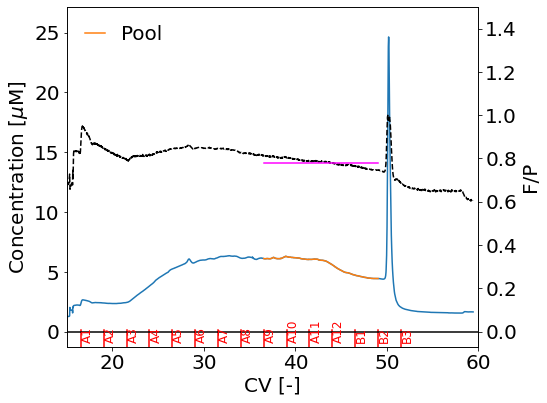

In [14]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV [-]')

ax.set_ylabel(r'Concentration [$\mu$M]')
ax.plot(df.UV_280nm_cv, df.c_280_M*1e6)
# ax.plot(df.UV_280nm_cv, df.c_280_M_check*1e6)
ax.plot(df_pooled.UV_280nm_cv, df_pooled.c_280_M*1e6, label='Pool')

frac_times = [x for x in df['Fractions_cv'] if str(x) != 'nan']
frac_names = [x for x in df['Fractions_(Fractions)'] if str(x) != 'nan']
for (time, name) in zip(frac_times, frac_names):
    if name == 'A9':
        cv_start = time
    elif name == 'B2':
        cv_end   = time
df_pooled = df[(cv_start < df.UV_280nm_cv) & (df.UV_280nm_cv < cv_end)].copy()

ax2 = ax.twinx()
ax2.set_ylabel('F/P')
ax2.plot(df.UV_280nm_cv, df.fp_280, 'k--')
ax2.set_ylim(0, 1.5)
ax2.plot([df_pooled.at[8016, 'UV_280nm_cv'], df_pooled.at[10756, 'UV_280nm_cv']],
       [fp_mean, fp_mean], color='magenta', label='Mean F/P')

xmax = 60
xmin = 15
ax.set_xlim(xmin, xmax)

my_plot.align_yaxis_multiple([ax, ax2])
my_plot.add_fractions(ax, df, x_conversion=1.0, text=True, xlim_times=(xmin, xmax))
my_plot.set_layout(fig, ax, legend=True, loc='upper left')
# fig.savefig(f'./images/F_to_P_from_refractionation.png', dpi=300)

# Pe correlation validation
## Prepare data for simulation

In [15]:
# Input data from previous section
extinction_lys_280 = 37970 # M-1 cm-1
extinction_fluor = 68000
cf = 0.3

# Calculated data from the previous section
# fp_mean = 0.7824664584891085 # Simple average - calculated value
fp_mean = 0.7808686152435612 # Weighted average - calculated value
# fp_mean = 0.63435186 # Optimized value to minimize c_mAb variation

# New data
extinction_mAb_mass = 1.57
mAb_mass = 146000
extinction_mAb = extinction_mAb_mass * mAb_mass

lys_mass = 14300

In [16]:
# Select data frames and compute Pe numbers
data_nums = [8, 7, 10, 9]
dic_vel = {6:152, 7:91, 8:30, 9:305, 10:213} # velocity in cm/h
dic_flow = {6:0.5, 7:0.3, 8:0.1, 9:1.0, 10:0.7} # flow in ml/min

d_particle = 9.0e-5
eps_c = 0.34456262415678807
Dp = 4.3e-11

plot_dic = {}
for i in data_nums:
    plot_dic[i] = d_particle * dic_vel[i] / (eps_c * 100 * 3600 * Dp)

In [17]:
# Data preparation - calculate concentrations of the FITC-lysozyme and mAb
for i in data_nums:
    file = files_dic[i]
    df = data_break[file].df
    flow = dic_flow[i]
    df['UV_280nm_time_s'] = df.UV_280nm_ml * 60 / flow
    
    # Interpolation to get 495 nm absorbance on the same volume axis as 280 nm 
    x = df.UV_280nm_cv.astype('float64')
    xp = df.UV_495nm_cv.astype('float64')
    yp = df.UV_495nm_mAU.astype('float64')
    df['UV_495_mAU_for_280_cv'] = np.interp(x, xp, yp)

    # Calculation of FITC-lysozyme concentration from A495 given the mean F/P ratio
    df['c_conj_280_M'] = df.UV_495_mAU_for_280_cv/(1000 * extinction_fluor * fp_mean)
    df['c_conj_280_mg_ml'] = df['c_conj_280_M'] * lys_mass
    
    # Smoothed FITC-lysozyme concentration
    # Not sure if this will even be used, but if so, I need to take a slice 
    # just eyballing it, from CV = 1.5 to 19
    x = np.array(df.UV_280nm_cv.dropna())
    y = np.array(df.c_conj_280_M.dropna())
    yhat = savgol_filter(y, 251, 3)
    res = np.empty(len(df.UV_280nm_cv))
    res[:len(x)] = yhat
    df['c_conj_280_M_smoothed'] = res
    
    # Calculation of mAb concentration 
    df['conj_contribution_280_mAU'] = df['c_conj_280_M'] * extinction_lys_280 * 1000 + df['UV_495_mAU_for_280_cv'] * cf
    df['c_mAb_280_M'] = (df.UV_280nm_mAU - df['conj_contribution_280_mAU'])/(1000 * extinction_mAb)
    df['c_mAb_280_mg_ml'] = df['c_mAb_280_M'] * mAb_mass

In [18]:
# Extraction of relevant data for simulations and zero the time
cleaned_data = {}
for i in data_nums:
    file = files_dic[i]
    df = data_break[file].df
    
    df_new = df.copy()
    df_new.UV_280nm_cv -= df_new.at[1, 'Inject_cv']
    df_new = df_new[(0.0 <= df_new.UV_280nm_cv) & (df_new.UV_280nm_cv <= 20.0)].copy()
    df_new.reset_index(inplace=True, drop=True)
    df_new.UV_280nm_time_s -= df_new.at[0, 'UV_280nm_time_s']
    cleaned_data[i] = df_new

## Plot data

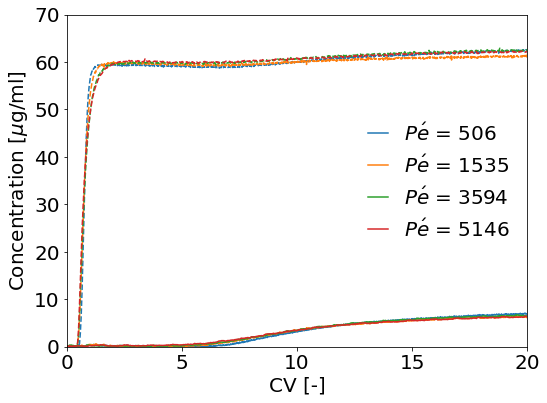

In [19]:
fig, ax = my_plot.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'Concentration [$\mu$g/ml]')

for i in data_nums:
    file = files_dic[i]
    df = data_break[file].df
    label = fr'$P\'{{e}}$ = {plot_dic[i]:.0f}'

    x = df.UV_280nm_cv - df.at[1, 'Inject_cv']
    ax.plot(x, df['c_conj_280_mg_ml']*1000, label=label)
    ax.plot(x, df['c_mAb_280_mg_ml']*1000, '--', color=plt.gca().lines[-1].get_color())
    
ax.set_xlim(0, 20)
ax.set_ylim(0, 70)

my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/troubleshooting/extracted_concentrations_mass_measured_FP.png', dpi=300)

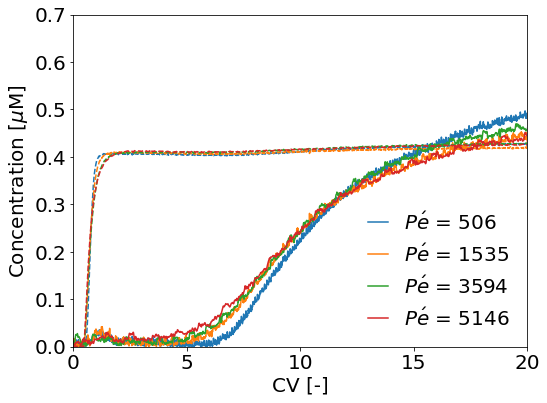

In [20]:
fig, ax = my_plot.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'Concentration [$\mu$M]')

for i in data_nums:
    file = files_dic[i]
    df = data_break[file].df
    label = fr'$P\'{{e}}$ = {plot_dic[i]:.0f}'

    x = df.UV_280nm_cv - df.at[1, 'Inject_cv']
    ax.plot(x, df['c_conj_280_M']*1e6, label=label)
    ax.plot(x, df['c_mAb_280_M']*1e6, '--', color=plt.gca().lines[-1].get_color())
    
ax.set_xlim(0, 20)
ax.set_ylim(0, 0.7)

my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/troubleshooting/extracted_concentrations_moles_measured_FP.png', dpi=300)

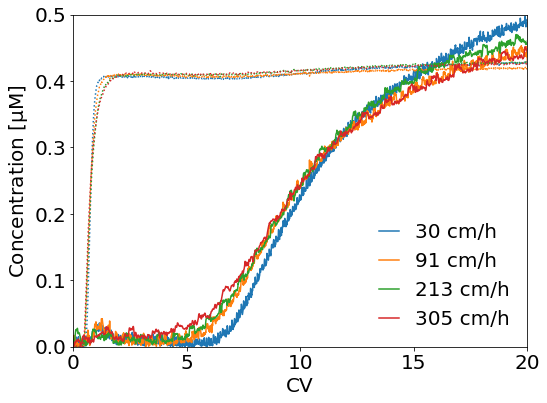

In [23]:
fig, ax = my_plot.instantiate_fig(8, 6)
ax.set_xlabel('CV')
ax.set_ylabel(r'Concentration [$\rm{\mu}$M]')

for i in data_nums:
    file = files_dic[i]
    df = data_break[file].df
    label = fr'{dic_vel[i]:.0f} cm/h'

    x = df.UV_280nm_cv - df.at[1, 'Inject_cv']
    ax.plot(x, df['c_conj_280_M']*1e6, label=label)
    ax.plot(x, df['c_mAb_280_M']*1e6, ':', color=plt.gca().lines[-1].get_color())
    
ax.set_xlim(0, 20)
ax.set_ylim(0, 0.5)

my_plot.set_layout(fig, ax, legend=True)
fig.savefig('./images/manuscript_images/FITC_lysozyme_concentration.png', dpi=300, bbox_inches='tight')
fig.savefig('./images/manuscript_images/FITC_lysozyme_concentration.pdf', bbox_inches='tight')

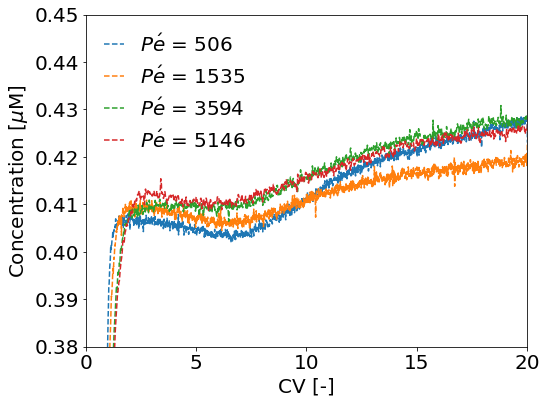

In [37]:
fig, ax = my_plot.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'Concentration [$\mu$M]')

for i in data_nums:
    file = files_dic[i]
    df = data_break[file].df
    label = fr'$P\'{{e}}$ = {plot_dic[i]:.0f}'

    x = df.UV_280nm_cv - df.at[1, 'Inject_cv']
#     ax.plot(x, df['c_conj_280_M']*1e6, label=label)
    ax.plot(x, df['c_mAb_280_M']*1e6, '--', label=label)
    
ax.set_xlim(0, 20)
ax.set_ylim(0.38, 0.45)

# ax.axvline(3)
my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/troubleshooting/extracted_concentrations_moles_fit_FP_mAb_plateau.png', dpi=300)

## Post-hoc estimation of mean F/P 
Finding the F/P which minimizes c_mAb variation following the initial mAb breakthrough 

In [446]:
def get_var_measure(fp_mean):
    vals = []
    # Data preparation - calculate concentrations of the FITC-lysozyme and mAb
    for i in data_nums:
        file = files_dic[i]
        df = data_break[file].df
        flow = dic_flow[i]
        df['UV_280nm_time_s'] = df.UV_280nm_ml * 60 / flow

        # Interpolation to get 495 nm absorbance on the same volume axis as 280 nm 
        x = df.UV_280nm_cv.astype('float64')
        xp = df.UV_495nm_cv.astype('float64')
        yp = df.UV_495nm_mAU.astype('float64')
        df['UV_495_mAU_for_280_cv'] = np.interp(x, xp, yp)

        # Calculation of FITC-lysozyme concentration from A495 given the mean F/P ratio
        df['c_conj_280_M'] = df.UV_495_mAU_for_280_cv/(1000 * extinction_fluor * fp_mean)
        df['c_conj_280_mg_ml'] = df['c_conj_280_M'] * lys_mass

        # Smoothed FITC-lysozyme concentration
        # Not sure if this will even be used, but if so, I need to take a slice 
        # just eyballing it, from CV = 1.5 to 19
        x = np.array(df.UV_280nm_cv.dropna())
        y = np.array(df.c_conj_280_M.dropna())
        yhat = savgol_filter(y, 251, 3)
        res = np.empty(len(df.UV_280nm_cv))
        res[:len(x)] = yhat
        df['c_conj_280_M_smoothed'] = res

        # Calculation of mAb concentration 
        df['conj_contribution_280_mAU'] = df['c_conj_280_M'] * extinction_lys_280 * 1000 + df['UV_495_mAU_for_280_cv'] * cf
        df['c_mAb_280_M'] = (df.UV_280nm_mAU - df['conj_contribution_280_mAU'])/(1000 * extinction_mAb)
        df['c_mAb_280_mg_ml'] = df['c_mAb_280_M'] * mAb_mass

        # Extraction of relevant data for simulations and zero the time
        df_new = df.copy()
        df_new.UV_280nm_cv -= df_new.at[1, 'Inject_cv']
        df_new = df_new[(3.0 <= df_new.UV_280nm_cv) & (df_new.UV_280nm_cv <= 20.0)].copy()
        df_new.reset_index(inplace=True, drop=True)
        df_new['c_mAb_280_nM'] = 1e9 * df_new['c_mAb_280_M']
        vals.append(df_new['c_mAb_280_nM'].var())
#         vals.append(df_new['c_mAb_280_nM'].mean())
    return np.sum(np.array(vals))
#     return np.mean(np.array(vals))

In [447]:
optimize.minimize(get_var_measure, x0=0.7)

      fun: 14.54924434713184
 hess_inv: array([[4.5411901e-05]])
      jac: array([-5.96046448e-07])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.63435186])

In [448]:
# load_c = get_var_measure(0.63435186)*1e-3 # uM, for fit F/P, (I modified the fun)
# load_c

# Column simulations of mAb flow-through

In [16]:
def get_mAb_residual(params, c_load, Keq, Ds, eps_c, flow, df, file):
    Dp, eps_p = params
    Dp *= 1e-11
    
    max_t = np.array(df.UV_280nm_time_s)[-1]
    df_start = df[df.UV_280nm_time_s < 0.1*max_t]
    
    ax.set_xlim(-1, 0.1*max_t)
    Dax = cadet_utils.get_Dax(flow)
    data_time = list(df_start['UV_280nm_time_s'])
    simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                  Dp=Dp, Ds=Ds, eps_c=eps_c, eps_p=eps_p, data_time=data_time, 
                  flow=flow)
    file_name = file[:file.find('.xls')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    cadet_utils.run_simulation(simulation, file_path)
    simulation.load()
    c_sim = simulation.root.output.solution.unit_004.solution_outlet_comp_000*1e3
    c_exp = df_start.c_mAb_280_M*1e6
    
    return np.array(c_sim, dtype=float) - np.array(c_exp, dtype=float)

In [450]:
results = []
for i in data_nums:
    Dp = 0.5
    eps_p = 0.43557765

    c_load = 0.4059597653701412e-3 # Found for fit F/P, should be close generally

    Keq = 0.0
    Ds  = 0.0
    eps_c = 0.34456262415678807

    flow = dic_flow[i]
    df = cleaned_data[i]
    file = files_dic[i]

    guess = (Dp, eps_p)
    args = (c_load, Keq, Ds, eps_c, flow, df, file)
    res = optimize.least_squares(get_mAb_residual, guess, args=args)

    results.append(res.x)

results = np.array(results)
results

array([[0.70461463, 0.43776566],
       [0.68785788, 0.42391003],
       [0.85907711, 0.47091292],
       [0.92212376, 0.44900506]])

In [451]:
# With measured F/P
results[:,0].mean(), results[:,1].mean()

(0.793418346799518, 0.44539841932930935)

In [434]:
# With fit F/P
results[:,0].mean(), results[:,1].mean()

(0.7796999024765303, 0.4474802498896533)

In [17]:
# Measured F/P
# Dp, eps_p = 0.793418346799518e-11, 0.44539841932930935

# # Fit F/P
Dp = 0.7796999024765303e-11
eps_p = 0.4474802498896533

c_load = 0.4059597653701412e-3 # mM, found for fit F/P, should be close generally

Keq = 0.0
Ds  = 0.0
eps_c = 0.34456262415678807

for i in data_nums:
    flow = dic_flow[i]
    Dax = cadet_utils.get_Dax(flow)
    data_time = list(cleaned_data[i]['UV_280nm_time_s'])
    
    simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                                                  Dp=Dp, Ds=Ds, eps_c=eps_c, 
                                                  eps_p=eps_p, data_time=data_time,
                                                  flow=flow)
    file_name = files_dic[i][:files_dic[i].find('.xls')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    cadet_utils.run_simulation(simulation, file_path)

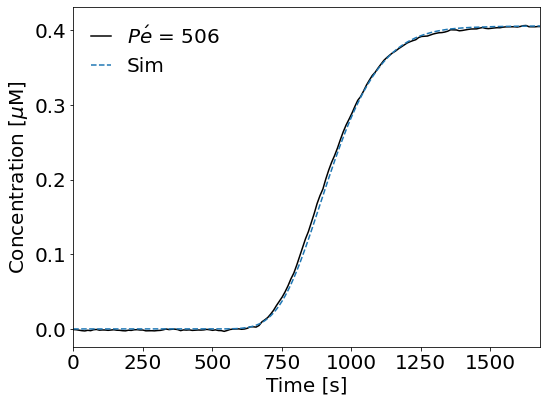

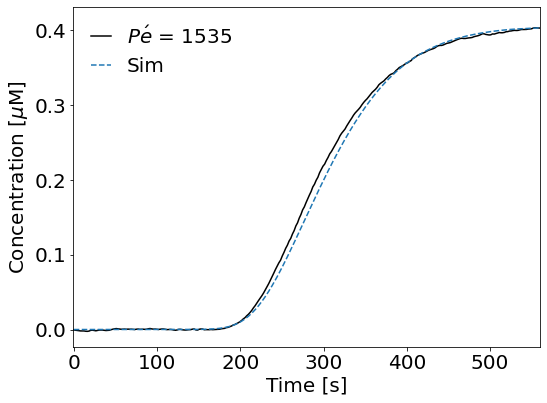

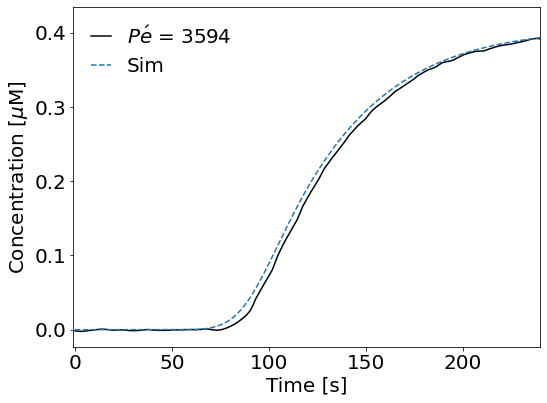

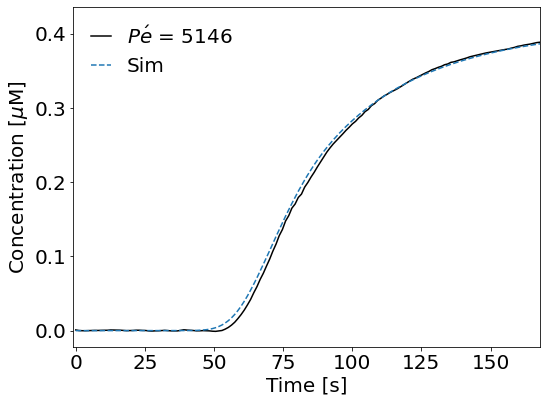

In [19]:
for i in data_nums:
    fig, ax = my_plot.instantiate_fig(8, 6)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(r'Concentration [$\mu$M]')
    
    df = cleaned_data[i]
    label = fr'$P\'{{e}}$ = {plot_dic[i]:.0f}'
    ax.plot(df.UV_280nm_time_s, df.c_mAb_280_M*1e6, label=label, color='black')

    file_name = files_dic[i][:files_dic[i].find('.xls')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    ax.plot(t, c_out*1e3, linestyle='--', label='Sim')

    max_t = np.array(df.UV_280nm_time_s)[-1]
    ax.set_xlim(-1, 0.07*max_t)
    my_plot.set_layout(fig, ax, legend=True)
#     fig.savefig(f'./images/FP_options/sim_fit_FP_Pe_{plot_dic[i]:.0f}.png', dpi=300)

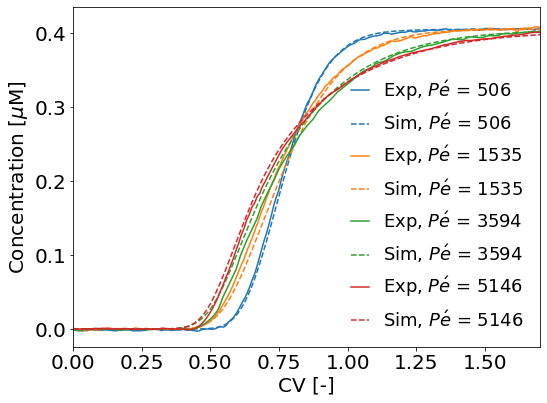

In [515]:
fig, ax = my_plot.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'Concentration [$\mu$M]')

for i in data_nums:
    factor = dic_flow[i] / (60.0 * 2)
    df = cleaned_data[i]
    label = fr'$P\'{{e}}$ = {plot_dic[i]:.0f}'
    ax.plot(df.UV_280nm_time_s * factor, df.c_mAb_280_M*1e6, label='Exp, ' +label)

    file_name = files_dic[i][:files_dic[i].find('.xls')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    ax.plot(t * factor, c_out*1e3, linestyle='--', 
            color=plt.gca().lines[-1].get_color(), label='Sim, ' +label)

ax.legend(loc='best', handlelength=1, frameon=False, fontsize=18)
ax.set_xlim(0.0, 1.7)
my_plot.set_layout(fig, ax)
# fig.savefig(f'./images/Fit_mAb_breakthrough.png', dpi=300)

# Column simulations of FITC-lysozyme

In [20]:
max_vals = []
for i in data_nums:
    df = cleaned_data[i]
    max_vals.append(df.c_conj_280_M.max())
    
c_load = np.mean(np.array(max_vals))*1e3 # mM
c_load

0.0005758888709975381

In [21]:
def get_conj_residual(params, c_load, Dp, eps_p, eps_c, flow, df, file):
    Keq, Ds = params
    Ds *= 1e-15
    
    Dax = cadet_utils.get_Dax(flow)
    data_time = list(df['UV_280nm_time_s'])
    simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                  Dp=Dp, Ds=Ds, eps_c=eps_c, eps_p=eps_p, data_time=data_time, 
                  flow=flow)
    file_name = file[:file.find('.xls')] + '_conjugate.h5'
    file_path = './hdf5_simulation_files/' + file_name
    cadet_utils.run_simulation(simulation, file_path)
    simulation.load()
    c_sim = simulation.root.output.solution.unit_004.solution_outlet_comp_000*1e3
    c_exp = df.c_conj_280_M*1e6
    
    return np.array(c_sim, dtype=float) - np.array(c_exp, dtype=float)

def get_conj_residual_combined(params, data_nums, eps_c):
    Keq, Dp, Ds, eps_p = params
    
    norms = []
    for i in data_nums:
        flow = dic_flow[i]
        df = cleaned_data[i]
        c_load = df.c_conj_280_M.max()*1e3 # mM, I know this is fudging it somewhat
        
        Dax = cadet_utils.get_Dax(flow)
        data_time = list(df['UV_280nm_time_s'])
        simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                      Dp=Dp, Ds=Ds, eps_c=eps_c, eps_p=eps_p, data_time=data_time, 
                      flow=flow)

        directory='./hdf5_simulation_files'
        f = next(tempfile._get_candidate_names())
        simulation.filename = os.path.join(directory, f + '.h5')
        simulation.save()
        data = simulation.run()
        assert data.returncode == 0
        simulation.load()

        c_sim = simulation.root.output.solution.unit_004.solution_outlet_comp_000*1e3
        c_exp = df.c_conj_280_M*1e6
        norm = np.linalg.norm(np.array(c_sim, dtype=float) - np.array(c_exp, dtype=float))
        norms.append(norm)
        
        os.remove(os.path.join('./hdf5_simulation_files', f + '.h5'))
    
    my_list = [np.array(norms).sum(), Keq, Dp, Ds, eps_p]
    print(np.array(my_list))
    return np.array(norms).sum()

In [17]:
# Everything together
eps_c = 0.34456262415678807

args = (data_nums, eps_c)
bounds = [(80, 110), (0.1e-11, 5.0e-11), (1.0e-15, 3.0e-11), (0.45, 0.9)]

fit = optimize.differential_evolution(get_conj_residual_combined,
                                      bounds, args=args, disp=True, workers=-1, updating='deferred')

[5.50466888e+01 1.01216797e+02 1.84898745e-11 4.16705480e-14
 6.75187031e-01][4.22379144e+01 8.02039285e+01 1.47652724e-11 5.65789986e-12
 7.09259416e-01]

[7.10533838e+01 8.96295294e+01 1.66194372e-11 1.02428405e-11
 4.79820310e-01]
[2.86309981e+01 8.07285207e+01 2.48274965e-11 1.32731619e-11
 8.78246289e-01]
[6.97539177e+01 1.01900857e+02 6.58879843e-12 2.66436034e-11
 6.54732194e-01]
[7.10909623e+01 1.03646141e+02 3.24668601e-11 2.35130184e-11
 5.14583102e-01]
[4.83325850e+01 1.04682396e+02 1.05708620e-12 1.61489751e-11
 7.61793931e-01]
[7.10905107e+01 1.09881250e+02 2.83668372e-11 2.72244795e-11
 5.47095116e-01]
[7.05539465e+01 8.68382546e+01 2.18234973e-11 2.03488802e-11
 5.64762963e-01]
[3.20148256e+01 9.93874400e+01 4.86216485e-12 4.43561324e-12
 7.92131430e-01]
[6.45171756e+01 1.05430982e+02 6.84179606e-12 1.09542900e-12
 6.71502817e-01]
[7.00208836e+01 8.58051142e+01 1.01734900e-11 4.51371273e-12
 5.51151057e-01]
[1.56409437e+01 1.00652973e+02 4.47170135e-11 1.93403259e-11
 8.

 7.16368383e-01]
[1.49239572e+01 8.80229400e+01 3.79930110e-11 1.14566124e-11
 8.40596586e-01]
[7.10337550e+01 8.68458396e+01 2.97546994e-11 1.26493570e-11
 4.85868802e-01]
[5.41563252e+01 9.24940006e+01 3.51687163e-11 8.26527184e-12
 7.12041972e-01]
[4.86644783e+01 8.98454529e+01 2.72665075e-11 1.23364172e-11
 7.23490763e-01]
[1.58411844e+01 9.77224595e+01 4.44550799e-11 2.51857187e-11
 8.55470050e-01]
[3.12712450e+01 8.38542274e+01 4.49202664e-11 1.07574983e-11
 8.89242454e-01]
[4.31955013e+01 8.52731848e+01 3.18533866e-11 1.02218365e-11
 7.26522620e-01]
[4.47987557e+01 8.11092747e+01 3.53791983e-11 9.83759613e-12
 7.06571543e-01]
[7.01674125e+01 8.67439284e+01 2.05416848e-11 2.00570285e-11
 5.81867721e-01]
[6.98671281e+01 9.53585293e+01 3.53017107e-11 8.86844843e-12
 6.20248350e-01]
[2.38742339e+01 9.34539598e+01 3.81721922e-11 1.31067252e-11
 8.84087379e-01]
[7.07057001e+01 1.07059390e+02 3.15056960e-11 1.82382594e-11
 6.38811903e-01]
[6.53309429e+01 8.77144383e+01 3.43212296e-11 9

 8.59059460e-01]
[1.38459109e+01 9.43761585e+01 2.72520805e-11 6.58863282e-12
 8.50956399e-01]
[2.68477121e+01 8.65353257e+01 4.58216511e-11 4.79621498e-12
 7.79501646e-01]
[3.52854840e+01 9.85080828e+01 2.74699877e-11 2.02689162e-11
 7.87500055e-01]
[1.49401740e+01 8.79415673e+01 3.60483268e-11 9.89256948e-12
 8.44949851e-01]
[5.78375436e+01 8.48906660e+01 3.22850496e-11 2.64135505e-11
 6.75123042e-01]
[2.14550933e+01 9.77717390e+01 1.15039976e-11 4.83061688e-12
 8.18390379e-01]
[2.11247890e+01 8.68458396e+01 2.97546994e-11 3.88023138e-12
 8.71231836e-01]
[2.45833815e+01 9.58957481e+01 4.45787570e-11 1.58535603e-11
 8.11883729e-01]
[1.50925494e+01 9.46364220e+01 2.72665075e-11 5.24430722e-12
 8.63636133e-01]
[2.69392745e+01 8.70523097e+01 3.74341600e-11 7.04862641e-12
 8.84152938e-01]
[2.22384900e+01 8.69669815e+01 3.79930110e-11 1.30331172e-12
 7.88006449e-01]
[4.16479504e+01 8.84503585e+01 1.30165960e-11 1.31808582e-11
 7.41859016e-01]
[2.23558942e+01 9.91871340e+01 2.85671751e-11 5

 8.35651946e-01]
[1.22933082e+01 9.27915032e+01 3.85360717e-11 2.10768204e-12
 8.51921436e-01]
[2.05578746e+01 8.54828202e+01 2.11026693e-11 8.33028427e-12
 8.65661380e-01]
[1.29947426e+01 1.05149280e+02 3.28648134e-11 1.53641975e-13
 8.79400814e-01]
[1.67570634e+01 1.06594708e+02 2.02214854e-11 1.63878304e-11
 8.55118475e-01]
[1.80385101e+01 9.10946395e+01 2.48583266e-11 2.84597108e-11
 8.26755585e-01]
[1.16535496e+01 8.65263358e+01 2.34141513e-11 2.70731288e-12
 8.35738420e-01]
[1.71962512e+01 9.50714517e+01 4.16075179e-11 4.07533891e-12
 8.27480551e-01]
[1.56496715e+01 9.83175853e+01 2.29429563e-11 1.78814571e-11
 8.51008319e-01]
[1.63349279e+01 1.00117237e+02 1.24567911e-11 1.72202590e-11
 8.47802591e-01]
[1.62108818e+01 9.50766246e+01 2.96194335e-11 5.65985442e-12
 8.32448882e-01]
[1.56521140e+01 9.28020353e+01 2.66274301e-11 1.22410225e-11
 8.37772944e-01]
[1.71192573e+01 8.93435345e+01 1.73783701e-11 2.04875348e-11
 8.56658907e-01]
[1.43345888e+01 9.73620108e+01 2.49537851e-11 5

 8.65250434e-01]
[1.93531272e+01 1.05818485e+02 3.09135654e-11 1.33125723e-11
 8.43866002e-01]
differential_evolution step 6: f(x)= 6.83151
[6.88568345e+00 9.00620955e+01 2.19384199e-11 1.82472989e-15
 8.37677509e-01]
[8.09730227e+00 8.38165710e+01 1.18303256e-11 1.14498036e-12
 8.28639552e-01]
[6.78003785e+00 9.41247464e+01 1.03038820e-11 5.36309049e-13
 8.44873751e-01]
[9.45444029e+00 8.65263358e+01 1.35792806e-11 1.64910522e-12
 8.32381758e-01]
[7.40157419e+00 9.23762644e+01 2.57560765e-12 1.08131302e-12
 8.36440998e-01]
[7.40735426e+00 8.96802373e+01 1.51056534e-11 2.65444781e-13
 8.42996877e-01]
[1.01169727e+01 9.03403504e+01 3.88751765e-11 5.30644427e-13
 8.39470236e-01]
[6.79510697e+00 9.25639652e+01 1.24078216e-11 2.13770612e-13
 8.40517747e-01]
[1.22586048e+01 1.02534775e+02 6.32618639e-12 4.31225576e-12
 8.57410907e-01]
[1.00966029e+01 8.70698637e+01 6.96377314e-12 2.29946829e-12
 8.39700711e-01]
[1.10071629e+01 9.69599112e+01 9.89903522e-12 3.72113457e-13
 8.66644756e-01]
[1

 8.39148482e-01]
[1.40303576e+01 9.77365866e+01 1.77689950e-11 4.45640101e-12
 8.42716082e-01]
[9.08800104e+00 9.64411612e+01 1.53868124e-12 2.17939072e-12
 8.47191564e-01]
[9.89157354e+00 9.04637048e+01 2.94356297e-12 2.57181683e-12
 8.43919934e-01]
[1.10824657e+01 1.08133513e+02 2.64376537e-12 4.69005787e-13
 8.44104317e-01]
[1.33663868e+01 8.96059312e+01 1.16332650e-11 5.26068474e-12
 8.33946121e-01]
[1.11061778e+01 9.27587089e+01 3.30857539e-11 1.45026663e-12
 8.41474413e-01]
[1.50409720e+01 9.61159194e+01 2.35100467e-11 1.21958096e-11
 8.48574415e-01]
[8.18284445e+00 9.63095604e+01 2.13094655e-11 4.16705480e-14
 8.39560554e-01]
[1.03436916e+01 9.71373022e+01 2.65007309e-11 1.19626508e-12
 8.47232012e-01]
[1.31956497e+01 8.59855137e+01 3.97483346e-11 3.49330119e-12
 8.40423875e-01]
[1.29632574e+01 9.48256385e+01 3.96058343e-11 3.50625621e-12
 8.47560182e-01]
[1.55560998e+01 9.56434255e+01 3.92270727e-11 3.35736604e-12
 8.32958935e-01]
[1.04240373e+01 9.28640809e+01 4.58553031e-11 2

 8.56846033e-01]
[8.72118839e+00 1.07649077e+02 2.25929754e-11 3.84974799e-13
 8.59041979e-01]
[1.55406654e+01 9.65876674e+01 2.06923678e-11 6.03612311e-13
 8.75871615e-01]
[1.26766897e+01 9.16543297e+01 4.65732042e-11 2.68223850e-12
 8.44074661e-01]
[1.43395912e+01 8.28711860e+01 1.60336695e-11 6.65551069e-12
 8.18174944e-01]
[1.55617057e+01 9.22686415e+01 2.17862290e-11 1.08346827e-11
 8.35818001e-01]
[7.95265263e+00 9.09978289e+01 3.84908394e-12 7.28858081e-13
 8.47655729e-01]
[1.38746054e+01 1.00170417e+02 4.98533203e-11 4.39308719e-12
 8.63539991e-01]
[1.31828596e+01 9.23579641e+01 4.26116578e-11 4.44576870e-14
 8.23834235e-01]
[9.74635804e+00 9.51344627e+01 3.66068694e-11 4.08797971e-13
 8.50239079e-01]
[1.24563352e+01 9.79874371e+01 2.97793562e-11 2.20935577e-12
 8.62935754e-01]
[1.58617231e+01 8.99511781e+01 3.84957920e-11 2.51657465e-11
 8.40596586e-01]
[2.28997871e+01 1.01030085e+02 3.95834867e-11 2.35227341e-11
 8.27287479e-01]
[1.48214955e+01 9.38242921e+01 1.19249639e-11 3

 8.46215588e-01]
[9.31038700e+00 8.82175040e+01 1.21942162e-11 8.76449525e-13
 8.46764593e-01]
[1.18088852e+01 8.99027262e+01 8.19131489e-12 7.29976141e-13
 8.58340411e-01]
[1.54057074e+01 8.82313721e+01 1.26173408e-11 1.91861564e-11
 8.40533615e-01]
[1.93775313e+01 1.07073088e+02 7.63542130e-12 3.31660699e-13
 8.21114217e-01][7.81986314e+00 9.12630893e+01 1.52741011e-12 1.45493717e-12
 8.46632670e-01]

[9.56844712e+00 9.14721574e+01 3.71875177e-11 1.08635342e-13
 8.36063680e-01][9.93048602e+00 9.64604433e+01 1.37478644e-11 9.99734202e-13
 8.38629048e-01][1.13039993e+01 9.52678243e+01 4.06306716e-11 1.27798297e-12
 8.47858173e-01]


[7.71290069e+00 9.16032349e+01 1.40136809e-11 5.77357781e-13
 8.46897096e-01]
[7.69952228e+00 8.86972399e+01 1.62216010e-11 5.84703053e-13
 8.31483794e-01]
[9.76462781e+00 9.63748853e+01 1.53282722e-11 8.53009781e-14
 8.62430851e-01]
[7.85643907e+00 9.52914558e+01 5.39677189e-12 2.76950672e-13
 8.37026442e-01]
[1.28270497e+01 9.93212874e+01 4.96397134e-11 2

 8.64587489e-01]
[8.53601501e+00 9.33524148e+01 2.91076406e-11 1.38702611e-13
 8.39560554e-01]
[1.64103122e+01 9.91682224e+01 1.03749475e-11 2.73520791e-11
 8.48853977e-01]
[1.62158662e+01 8.85868957e+01 1.16571927e-11 2.97202820e-11
 8.33099116e-01]
[1.50255274e+01 8.61861265e+01 2.27100494e-11 9.79709821e-12
 8.26929196e-01]
differential_evolution step 13: f(x)= 6.76682
[7.23875837e+00 9.23781512e+01 1.92193261e-11 2.30689598e-13
 8.45580433e-01]
[1.00250906e+01 1.05429503e+02 1.61168711e-12 2.25280379e-13
 8.47543053e-01]
[7.81416432e+00 1.01236681e+02 1.00473532e-11 4.37949988e-13
 8.62863899e-01]
[7.37768797e+00 1.03410613e+02 1.72527588e-12 5.97518929e-13
 8.52404977e-01]
[9.34188617e+00 9.83844189e+01 4.29967459e-12 1.79449479e-13
 8.36063885e-01]
[6.89699470e+00 9.78580210e+01 1.36651427e-11 3.65799379e-13
 8.48252246e-01]
[9.06603549e+00 8.97246630e+01 5.56987368e-12 2.83348318e-13
 8.46548903e-01]
[7.58144754e+00 9.10883544e+01 2.44200019e-11 1.79921604e-13
 8.42087535e-01]
[

 8.28358975e-01]
[1.40770703e+01 1.04585510e+02 1.63828656e-11 6.08089784e-12
 8.56706021e-01]
[8.02489467e+00 8.73065242e+01 1.37726630e-11 2.20579834e-13
 8.41642041e-01]
[7.83456974e+00 9.07014543e+01 1.97670915e-11 5.59253433e-13
 8.41526475e-01]
[1.18362103e+01 1.01543116e+02 1.73750303e-11 4.01424973e-13
 8.37563129e-01][7.54512025e+00 9.16827446e+01 1.39070715e-11 5.64222839e-13
 8.46264707e-01]

[1.23014275e+01 8.91249786e+01 8.51732365e-12 1.45620413e-13
 8.56902304e-01]
[1.53982190e+01 9.42643523e+01 2.50570073e-11 1.16786730e-11
 8.41522782e-01]
[6.92770504e+00 9.22502526e+01 2.18603759e-11 2.84764417e-14
 8.42090703e-01]
[6.79817928e+00 9.22503125e+01 1.42409609e-11 3.34050822e-13
 8.40582123e-01]
[7.00555914e+00 9.11631353e+01 1.47810096e-11 4.53268368e-13
 8.41678598e-01]
[1.11075313e+01 8.38209666e+01 1.71970258e-11 3.26946626e-13
 8.45500081e-01]
[1.22602658e+01 9.28771393e+01 3.14121451e-11 2.11890916e-12
 8.54210665e-01]
[1.03843936e+01 9.41618484e+01 2.73076048e-11 2

 8.35203093e-01]
[1.04025026e+01 8.13722268e+01 1.34481458e-11 1.50921982e-13
 8.38785632e-01]
[1.60534615e+01 9.23762644e+01 1.73102432e-11 2.92000600e-11
 8.42220081e-01]
[1.19868069e+01 9.23392672e+01 2.38521159e-11 1.64910522e-12
 8.32381758e-01]
[7.05440960e+00 9.28972292e+01 1.41160268e-11 5.33733064e-13
 8.44496526e-01]
[7.97680994e+00 8.70345449e+01 1.11162227e-11 3.08058072e-13
 8.40760749e-01]
[6.90112131e+00 9.10600683e+01 8.23484491e-12 3.76354581e-13
 8.39972743e-01]
[1.20526288e+01 9.43512475e+01 2.52616226e-11 2.65677735e-12
 8.54219611e-01]
[6.92968294e+00 9.89460213e+01 1.19044571e-11 4.99843359e-13
 8.54596811e-01]
[1.19894162e+01 8.67045631e+01 1.48007751e-11 6.96931524e-14
 8.53547902e-01]
[1.45902771e+01 9.80081624e+01 2.25962944e-11 1.02329648e-11
 8.54874121e-01]
[6.77624832e+00 9.43608717e+01 1.38473852e-11 2.93280912e-13
 8.43793926e-01]
[6.86277336e+00 9.14225797e+01 1.64190198e-11 3.73663267e-14
 8.36687425e-01]
[6.86134770e+00 8.67321313e+01 8.47491604e-12 7

 8.16875521e-01]
[8.43891364e+00 9.21611540e+01 1.56786630e-11 4.66485490e-13
 8.32381758e-01]
[7.35483357e+00 9.99657184e+01 1.88322785e-11 2.87328956e-13
 8.57748330e-01]
[7.07359571e+00 8.80270901e+01 1.36316039e-11 4.06288383e-13
 8.37723923e-01]
[7.41590505e+00 8.45630084e+01 1.71793828e-11 7.49431102e-14
 8.33447656e-01]
[7.02359008e+00 9.74407290e+01 1.53938398e-11 4.48254542e-13
 8.49625441e-01]
[7.53092192e+00 9.42536817e+01 6.83805572e-12 6.26794283e-13
 8.37188083e-01]
[7.99489647e+00 8.75140252e+01 1.57967797e-11 2.47016084e-13
 8.22967159e-01][1.53815425e+01 8.78816332e+01 1.65614020e-11 1.79014937e-11
 8.41086856e-01]

[8.03013716e+00 8.88803637e+01 2.28240540e-11 4.49684551e-13
 8.38952689e-01]
[7.06108446e+00 9.33691995e+01 1.12225044e-11 9.78440121e-14
 8.39130040e-01]
[1.16088718e+01 9.63238035e+01 1.65861901e-11 1.54496511e-12
 8.37709026e-01]
[7.87920524e+00 8.80463218e+01 1.75253741e-11 3.47211613e-13
 8.41614317e-01]
[1.55748326e+01 8.86729127e+01 1.39486928e-11 2

 8.48462152e-01]
[1.69332030e+01 9.39195704e+01 2.59338803e-11 2.69517437e-11
 8.37454123e-01]
[6.85517707e+00 8.98864729e+01 5.21882490e-12 7.12896180e-13
 8.39080406e-01]
[7.36179257e+00 9.58662076e+01 1.39946651e-11 5.36486745e-13
 8.43877579e-01]
[1.46729766e+01 9.28155172e+01 2.24902016e-11 1.00853526e-11
 8.43740241e-01]
[1.61132138e+01 8.68912105e+01 1.85273485e-11 2.55325862e-11
 8.30004411e-01]
[1.20038922e+01 9.96628497e+01 2.03413749e-11 3.24938227e-12
 8.55632696e-01]
[1.49910381e+01 9.67471618e+01 2.53955125e-11 1.27738585e-11
 8.55602365e-01]
differential_evolution step 20: f(x)= 6.76288
[6.91050548e+00 9.62997600e+01 7.34398974e-12 6.62583996e-13
 8.50703340e-01]
[6.83365081e+00 9.25639652e+01 1.58822232e-12 1.05327044e-12
 8.40517747e-01]
[7.81830661e+00 9.98899756e+01 5.84946032e-12 1.79921604e-13
 8.53857290e-01]
[7.01817321e+00 1.02914211e+02 1.19655736e-11 6.32710541e-13
 8.57469761e-01]
[1.69094433e+01 8.08785022e+01 1.35290182e-11 5.20110176e-13
 8.56430479e-01]
[

 8.33326847e-01]
[8.02984286e+00 8.90353248e+01 1.67720898e-11 7.98907883e-13
 8.35100616e-01]
[7.20296850e+00 9.14395398e+01 1.38530946e-11 6.28141578e-13
 8.39310505e-01]
[6.86350701e+00 9.45895837e+01 1.40545595e-11 3.45314040e-13
 8.43346042e-01]
[6.81015505e+00 9.72826563e+01 6.52556522e-12 5.21089636e-13
 8.48593886e-01]
[6.92584125e+00 9.74031023e+01 2.09993422e-12 9.00252677e-13
 8.52417412e-01]
[6.86397728e+00 9.26909404e+01 4.91701517e-12 6.79261050e-13
 8.43773264e-01]
[1.08633829e+01 9.13176254e+01 4.69415950e-11 5.49893775e-13
 8.40644704e-01]
[6.76722032e+00 9.69974079e+01 5.75421748e-12 6.57851562e-13
 8.48468410e-01]
[7.81719804e+00 9.16397955e+01 8.57735057e-12 4.71989735e-13
 8.30620389e-01]
[6.81146831e+00 9.30390448e+01 3.84244675e-12 9.62595170e-13
 8.43387078e-01]
[7.44788078e+00 9.51565506e+01 4.46605553e-12 3.34050822e-13
 8.40582123e-01]
[6.83344767e+00 9.08120547e+01 1.05193709e-11 4.97918521e-13
 8.36596591e-01]
[1.12941161e+01 1.01982289e+02 1.76804762e-11 2

[6.76233571e+00 9.44617435e+01 5.58071606e-12 7.19470659e-13
 8.45250389e-01]
[1.13505305e+01 9.44617435e+01 5.00000000e-11 7.19470659e-13
 8.45250389e-01]
[1.59411953e+01 9.44617435e+01 5.58071606e-12 3.00000000e-11
 8.45250389e-01]
[6.76491881e+00 9.44617435e+01 5.58071606e-12 7.19470659e-13
 8.45250399e-01]
[6.75886254e+00 9.44617383e+01 5.60698439e-12 7.23590764e-13
 8.44936425e-01]
[6.76000566e+00 9.44617383e+01 5.60698439e-12 7.23590764e-13
 8.44936425e-01]
[1.13752876e+01 9.44617383e+01 5.00000000e-11 7.23590764e-13
 8.44936425e-01]
[1.59676600e+01 9.44617383e+01 5.60698439e-12 3.00000000e-11
 8.44936425e-01]
[6.75993078e+00 9.44617383e+01 5.60698439e-12 7.23590764e-13
 8.44936435e-01]
[6.75840480e+00 9.44617358e+01 5.62015235e-12 7.25656115e-13
 8.44779039e-01]
[6.75779447e+00 9.44617358e+01 5.62015235e-12 7.25656115e-13
 8.44779039e-01]
[1.13889263e+01 9.44617358e+01 5.00000000e-11 7.25656115e-13
 8.44779039e-01]
[1.59815139e+01 9.44617358e+01 5.62015235e-12 3.00000000e-11
 8.

[1.14015819e+01 9.44617326e+01 5.00000000e-11 7.25454894e-13
 8.44586929e-01]
[1.59987885e+01 9.44617326e+01 5.61886943e-12 3.00000000e-11
 8.44586929e-01]
[6.75924741e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.44586939e-01]
[6.75929354e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.44586929e-01]
[6.75907783e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.44586929e-01]
[1.14005374e+01 9.44617326e+01 5.00000000e-11 7.25454894e-13
 8.44586929e-01]
[1.59991957e+01 9.44617326e+01 5.61886943e-12 3.00000000e-11
 8.44586929e-01]
[6.75906326e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.44586939e-01]
[6.75881453e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.44586929e-01]
[6.75968741e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.44586929e-01]
[1.14015819e+01 9.44617326e+01 5.00000000e-11 7.25454894e-13
 8.44586929e-01]
[1.59987885e+01 9.44617326e+01 5.61886943e-12 3.00000000e-11
 8.44586929e-01]
[6.75924741e+00 9.44617326e+01 5.61886943e-12 7.25454894e-13
 8.

[1.59992262e+01 9.44616707e+01 5.61884967e-12 3.00000000e-11
 8.44585241e-01]
[6.75969628e+00 9.44616707e+01 5.61884967e-12 7.25451794e-13
 8.44585251e-01]
[6.75895352e+00 9.44617217e+01 5.61886595e-12 7.25454348e-13
 8.44586632e-01]
[6.75925015e+00 9.44617217e+01 5.61886595e-12 7.25454348e-13
 8.44586632e-01]
[1.14006397e+01 9.44617217e+01 5.00000000e-11 7.25454348e-13
 8.44586632e-01]
[1.59992216e+01 9.44617217e+01 5.61886595e-12 3.00000000e-11
 8.44586632e-01]
[6.75986394e+00 9.44617217e+01 5.61886595e-12 7.25454348e-13
 8.44586642e-01]
[6.75979326e+00 9.44617296e+01 5.61886846e-12 7.25454742e-13
 8.44586846e-01]
[6.75913573e+00 9.44617296e+01 5.61886846e-12 7.25454742e-13
 8.44586846e-01]
[1.14002940e+01 9.44617296e+01 5.00000000e-11 7.25454742e-13
 8.44586846e-01]
[1.59985802e+01 9.44617296e+01 5.61886846e-12 3.00000000e-11
 8.44586846e-01]
[6.75982502e+00 9.44617296e+01 5.61886846e-12 7.25454742e-13
 8.44586856e-01]
[6.75914252e+00 9.44617312e+01 5.61886899e-12 7.25454824e-13
 8.

[6.75873405e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586937e-01]
[6.75792938e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586927e-01]
[6.75963229e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586927e-01]
[1.13994082e+01 9.44617325e+01 5.00000000e-11 7.24130986e-13
 8.44586927e-01]
[1.59985967e+01 9.44617325e+01 5.61042866e-12 3.00000000e-11
 8.44586927e-01]
[6.75833846e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586937e-01]
[6.75848669e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586927e-01]
[6.75864344e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586927e-01]
[1.13998708e+01 9.44617325e+01 5.00000000e-11 7.24130986e-13
 8.44586927e-01]
[1.59984529e+01 9.44617325e+01 5.61042866e-12 3.00000000e-11
 8.44586927e-01]
[6.75853774e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586937e-01]
[6.75792938e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.44586927e-01]
[6.75963229e+00 9.44617325e+01 5.61042866e-12 7.24130986e-13
 8.

[6.75873698e+00 9.44617323e+01 5.61042857e-12 7.24130972e-13
 8.44586920e-01]
[6.75929399e+00 9.44617323e+01 5.61042857e-12 7.24130972e-13
 8.44586920e-01]
[1.13998772e+01 9.44617323e+01 5.00000000e-11 7.24130972e-13
 8.44586920e-01]
[1.59995530e+01 9.44617323e+01 5.61042857e-12 3.00000000e-11
 8.44586920e-01]
[6.75911303e+00 9.44617323e+01 5.61042857e-12 7.24130972e-13
 8.44586930e-01]
[6.75943345e+00 9.44617324e+01 5.61042864e-12 7.24130982e-13
 8.44586925e-01]
[6.75815880e+00 9.44617325e+01 5.61042864e-12 7.24130982e-13
 8.44586925e-01]
[1.13998397e+01 9.44617324e+01 5.00000000e-11 7.24130982e-13
 8.44586925e-01]
[1.59982525e+01 9.44617324e+01 5.61042864e-12 3.00000000e-11
 8.44586925e-01]
[6.75940632e+00 9.44617324e+01 5.61042864e-12 7.24130982e-13
 8.44586935e-01]
[6.75931374e+00 9.44617325e+01 5.61042865e-12 7.24130984e-13
 8.44586926e-01]
[6.75929729e+00 9.44617325e+01 5.61042865e-12 7.24130984e-13
 8.44586926e-01]
[1.14005391e+01 9.44617325e+01 5.00000000e-11 7.24130984e-13
 8.

In [18]:
fit

     fun: 6.759170662426774
 message: 'Optimization terminated successfully.'
    nfev: 1905
     nit: 23
 success: True
       x: array([9.44617325e+01, 5.63686130e-12, 7.28276860e-13, 8.44579330e-01])

In [24]:
results = np.loadtxt('./collective_evolutionary_search_results.txt')
results[results[:,0]==results[:,0].min(), :]

array([[6.34774666e+00, 9.37920791e+01, 1.60131929e-11, 7.31281010e-14]])

In [16]:
# eps_p = 0.8421529231673788
# eps_c = 0.34456262415678807

# # Individual
# for i in [9]:
#     df = cleaned_data[i]
#     c_load = df.c_conj_280_M.max()*1e3 # mM, I know this is fudging it somewhat
    
#     print('Start of ', files_dic[i], '\n')
#     nums = [i]
#     args = (nums, c_load, eps_p, eps_c)
#     bounds = [(75, 110), (0.1, 5.0), (0.01, 10.0)]

#     fit = optimize.differential_evolution(get_conj_residual_combined,
#             bounds, args=args, disp=True, workers=-1, updating='deferred')
#     print('\n', files_dic[i])
#     print(fit)
#     print('\n')

Start of  CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 4.xls 

[2.04844385e+00 1.00481585e+02 4.97201697e-11 2.06056119e-13]
[5.65847770e+00 1.08852083e+02 1.28709645e-12 2.79389834e-14]
[1.70842059e+00 9.12848739e+01 4.76301614e-12 4.32961588e-13]
[2.08939107e+00 7.87098167e+01 3.06229732e-11 5.74212982e-13]
[1.26189376e+00 8.88249111e+01 4.67826904e-11 3.31740879e-13]
[1.77446126e+00 1.00690920e+02 3.80909676e-11 1.15270199e-13]
[3.63365464e+00 8.41310922e+01 5.85940301e-12 1.14785427e-14]
[2.55558022e+00 7.61468383e+01 4.17316710e-11 2.95894735e-13]
[2.94437124e+00 1.09864887e+02 3.29461452e-11 2.78778636e-13]
[2.70250621e+00 7.50631829e+01 3.41623192e-11 7.08880907e-13]
[2.39739637e+00 1.05480843e+02 2.54147601e-11 7.51038049e-13]
[1.05252863e+00 9.63116670e+01 2.34583678e-11 5.38301344e-13]
[8.49408943e-01 8.75871942e+01 2.25406734e-11 6.68092808e-13]
[1.69804800e+00 1.02830064e+02 2.23871984e-12 8.48394595e-13]
[1.31781900e+00 8.34496547e+01 1.43378411e-11 6.62666

[5.90072071e-01 9.07091792e+01 2.86881638e-11 8.25439473e-14]
[1.16223390e+00 9.27637457e+01 1.16759082e-11 2.35206862e-13]
[9.40564197e-01 8.84714002e+01 3.70303857e-11 1.50283047e-13]
[7.40985380e-01 9.22395059e+01 2.78383896e-11 3.76289711e-13]
[7.25445561e-01 9.04113583e+01 2.98044493e-11 2.91537750e-13]
[8.71328607e-01 8.69637970e+01 2.62084628e-11 3.05515395e-13]
[5.41125335e-01 9.11831836e+01 2.59950502e-11 4.81420024e-14]
[9.60473668e-01 8.85038110e+01 2.95721465e-11 6.48759732e-13]
[7.28971440e-01 9.36142951e+01 2.67856451e-11 2.52884179e-13]
[1.30019200e+00 9.07562630e+01 4.14142563e-11 7.71851721e-13]
[6.74788617e-01 8.93563552e+01 2.18630480e-11 8.79541517e-14]
differential_evolution step 5: f(x)= 0.541125
[1.47328676e+00 8.60636949e+01 1.24403591e-11 2.08940737e-13]
[6.42764604e-01 9.36819624e+01 9.33424920e-12 8.90583607e-13]
[9.16680187e-01 9.09532866e+01 1.39663178e-11 2.56044847e-13]
[6.14906118e-01 8.94851006e+01 2.67196156e-11 1.21188546e-13]
[6.43545391e-01 8.895393

[5.43404156e-01 9.15964662e+01 2.61676350e-11 4.59678427e-14]
[5.48666850e-01 9.12797971e+01 2.42847784e-11 5.52884026e-14]
[6.40602981e-01 9.17737294e+01 1.81917690e-11 2.28315704e-13]
[5.54902269e-01 9.21880952e+01 2.50990913e-11 5.77621564e-14]
[1.02911873e+00 9.06677619e+01 3.12935727e-11 7.71313649e-13]
[8.14154907e-01 9.09339540e+01 2.56349219e-11 6.98756431e-13]
[5.41987391e-01 9.10542424e+01 2.47283432e-11 1.19924238e-13]
[9.53885689e-01 9.09254609e+01 2.90727818e-11 7.49307404e-13]
[6.05284696e-01 9.06182157e+01 2.76676513e-11 1.77357603e-13]
[9.02822669e-01 9.05084425e+01 2.58609634e-11 8.52275583e-13]
[5.75785674e-01 9.25352724e+01 2.70082307e-11 2.32408420e-14]
[5.72630889e-01 9.18089268e+01 2.23292672e-11 9.82246582e-14]
[6.59168591e-01 9.05347140e+01 2.47313107e-11 4.66443785e-13][6.14301891e-01 9.12677504e+01 2.12238584e-11 5.79801775e-13][5.97263272e-01 8.95877376e+01 2.58796318e-11 6.60935435e-14]


[5.43997187e-01 9.09019061e+01 2.50907754e-11 8.78938622e-14]
[5.58910

[5.40495077e-01 9.13041351e+01 2.29989539e-11 2.04834676e-13]
[5.40495077e-01 9.13041351e+01 2.29989540e-11 2.04834676e-13]
[5.40495077e-01 9.13041351e+01 2.29989539e-11 2.04834677e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834667e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834667e-13]
[5.40490960e-01 9.13041352e+01 2.29989412e-11 2.04834667e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834668e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834667e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834667e-13]
[5.40490960e-01 9.13041352e+01 2.29989412e-11 2.04834667e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834668e-13]
[5.40495079e-01 9.13041352e+01 2.29989475e-11 2.04834672e-13]
[5.40495079e-01 9.13041352e+01 2.29989475e-11 2.04834672e-13]
[5.40495080e-01 9.13041352e+01 2.29989476e-11 2.04834672e-13]
[5.40495079e-01 9.13041352e+01 2.29989475e-11 2.04834673e-13]
[5.40490960e-01 9.13041352e+01 2.29989411e-11 2.04834667e-13]
[5.40490

In [25]:
individual_fits = {8:[100.40795203,   0.30522282,   0.16760185],
                  7:[92.49431865,  0.84223907,  0.32913036],
                  10:[92.9488875 ,  2.13349026,  0.49295705],
                  9:[91.30413521,  2.29989768,  2.04834631]}
fit_vals = []
for i in data_nums:
    fit_vals.append(individual_fits[i])
fit_vals = np.array(fit_vals)
Keq_mean = fit_vals[:,0].mean()
Dp_mean = fit_vals[:,1].mean()* 1e-11
Ds_mean = fit_vals[:,2].mean()* 1e-13

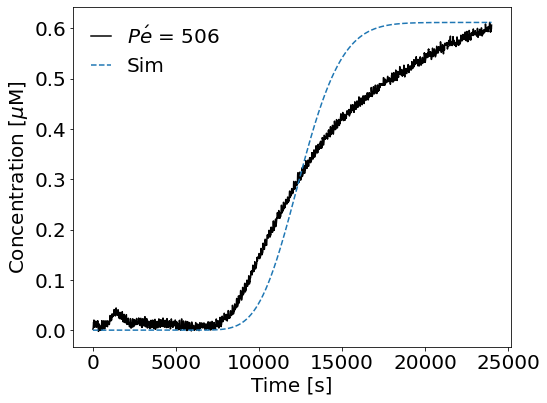

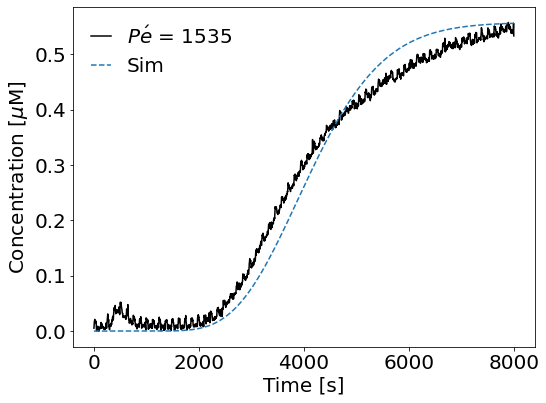

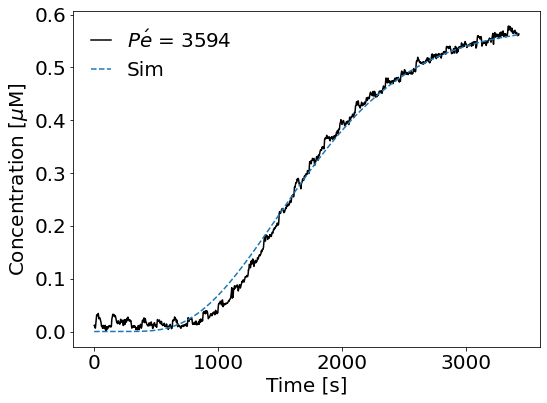

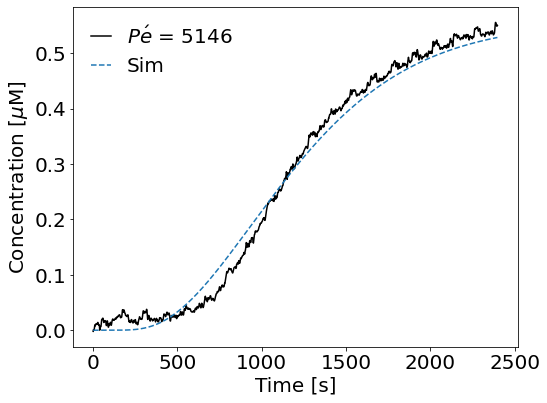

In [27]:
# Run simulations
eps_p = 0.8421529231673788
eps_c = 0.34456262415678807

# Keq, Dp, Ds = 85.0, 4.3e-11, 1.0e-13 # "Original" Dp
# Keq, Dp, Ds = 9.37920791e+01, 1.60131929e-11, 7.31281010e-14 # Collective fit
# Uncomment below for individual fits
# Keq, Dp, Ds = Keq_mean, Dp_mean, Ds_mean # average of individual fits
# c_load = 0.0005758888709975381 # average of max values
Keq, Dp, Ds, eps_p = (9.44617325e+01, 5.63686130e-12, 7.28276860e-13, 8.44579330e-01) # Collective fit, round 2, with unique c_load and eps_p

for i in data_nums:
#     Keq, Dp, Ds = individual_fits[i]
#     Dp *= 1e-11
#     Ds *= 1e-13
    df = cleaned_data[i]
    c_load = df.c_conj_280_M.max()*1e3 # mM, I know this is fudging it
    
    flow = dic_flow[i]
    Dax = cadet_utils.get_Dax(flow)
    data_time = list(cleaned_data[i]['UV_280nm_time_s'])
    
    simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                                                  Dp=Dp, Ds=Ds, eps_c=eps_c, 
                                                  eps_p=eps_p, data_time=data_time,
                                                  flow=flow)
    file_name = files_dic[i][:files_dic[i].find('.xls')] + '_conjugate.h5'
    file_path = './hdf5_simulation_files/' + file_name
    cadet_utils.run_simulation(simulation, file_path)
    
# Plot results
for i in data_nums:
    fig, ax = my_plot.instantiate_fig(8, 6)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(r'Concentration [$\mu$M]')
    
    df = cleaned_data[i]
    label = fr'$P\'{{e}}$ = {plot_dic[i]:.0f}'
    ax.plot(df.UV_280nm_time_s, df.c_conj_280_M*1e6, label=label, color='black')

    file_name = files_dic[i][:files_dic[i].find('.xls')] + '_conjugate.h5'
    file_path = './hdf5_simulation_files/' + file_name
    
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    ax.plot(t, c_out*1e3, linestyle='--', label='Sim')

    my_plot.set_layout(fig, ax, legend=True)
#     fig.savefig(f'./images/sim_FITC_lysozyme/Collective_fits_2_Pe_{plot_dic[i]:.0f}.png', dpi=300)

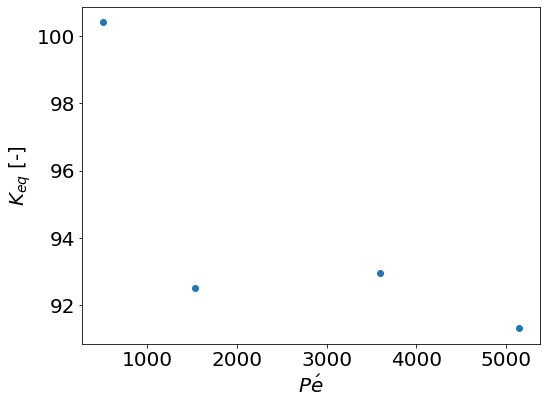

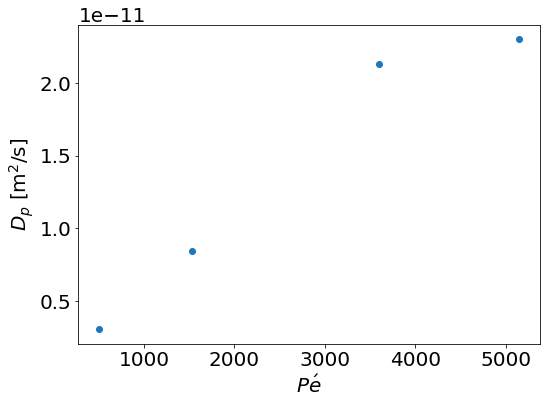

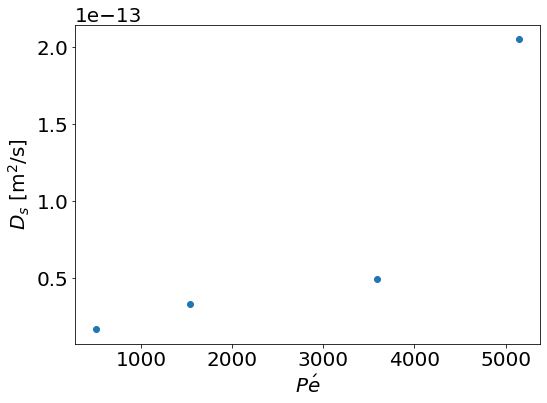

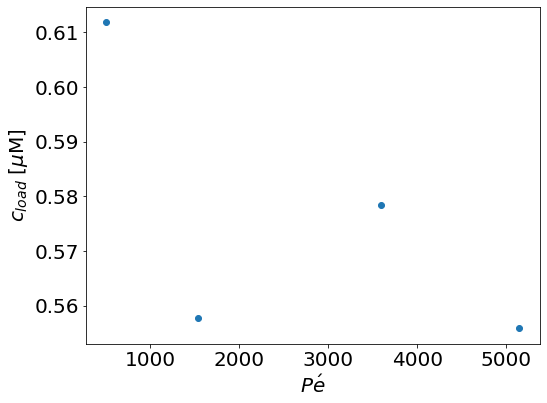

In [26]:
# Keq_vals, Dp_vals, Ds_vals, c_load_vals, pe_vals = [], [], [], [], []

# for i in data_nums:
#     Keq, Dp, Ds = individual_fits[i]
#     Dp *= 1e-11
#     Ds *= 1e-13
#     df = cleaned_data[i]
#     c_load = df.c_conj_280_M.max()*1e6 # uM
    
#     Keq_vals.append(Keq)
#     Dp_vals.append(Dp)
#     Ds_vals.append(Ds)
#     c_load_vals.append(c_load)
#     pe_vals.append(plot_dic[i])
    
# fig, ax = my_plot.instantiate_fig(8, 6)
# ax.set_xlabel(r'$P\'{{e}}$')
# ax.set_ylabel(r'$K_{eq}$ [-]')
# ax.scatter(pe_vals, Keq_vals)
# my_plot.set_layout(fig, ax)
# fig.savefig(f'./images/simulation_troubleshooting/Individual_fits_Keq.png', dpi=300)

# fig, ax = my_plot.instantiate_fig(8, 6)
# ax.set_xlabel(r'$P\'{{e}}$')
# ax.set_ylabel(r'$D_p$ [m$^2$/s]')
# ax.scatter(pe_vals, Dp_vals)
# my_plot.set_layout(fig, ax)
# fig.savefig(f'./images/simulation_troubleshooting/Individual_fits_Dp.png', dpi=300)

# fig, ax = my_plot.instantiate_fig(8, 6)
# ax.set_xlabel(r'$P\'{{e}}$')
# ax.set_ylabel(r'$D_s$ [m$^2$/s]')
# ax.scatter(pe_vals, Ds_vals)
# my_plot.set_layout(fig, ax)
# fig.savefig(f'./images/simulation_troubleshooting/Individual_fits_Ds.png', dpi=300)

# fig, ax = my_plot.instantiate_fig(8, 6)
# ax.set_xlabel(r'$P\'{{e}}$')
# ax.set_ylabel(r'$c_{load}$ [$\mu$M]')
# ax.scatter(pe_vals, c_load_vals)
# my_plot.set_layout(fig, ax)
# fig.savefig(f'./images/simulation_troubleshooting/Individual_fits_c_load.png', dpi=300)


# Multicomponent simulation

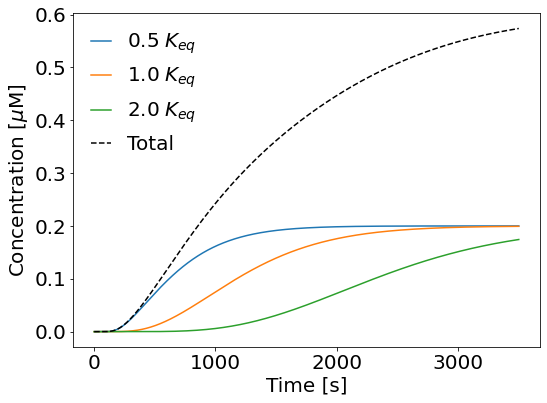

In [59]:
# Run simulations
eps_p = 0.8421529231673788
eps_c = 0.34456262415678807
flow = 1.0
Dax = cadet_utils.get_Dax(flow)
data_time = np.linspace(0, 3500, 3501)

base_val = 9.44617325e+01
Keq = np.array([base_val*0.5, base_val, base_val*2.0])
Dp = 5.63686130e-12 * np.ones(3)
Ds = 7.28276860e-13 * np.ones(3)
c_load = 0.0006/3.0 * np.ones(3)

simulation = cadet_utils.set_breakthrough_sim_multi(Keq=Keq, c_load=c_load,
                            Dax=Dax, Dp=Dp, Ds=Ds, eps_c=eps_c, eps_p=eps_p, 
                            data_time=data_time, flow=flow)

file_name = 'multicompenent_demo.h5'
file_path = './hdf5_simulation_files/' + file_name
cadet_utils.run_simulation(simulation, file_path)
simulation.load()
t   = simulation.root.output.solution.solution_times
c_0 = simulation.root.output.solution.unit_004.solution_outlet_comp_000
c_1 = simulation.root.output.solution.unit_004.solution_outlet_comp_001
c_2 = simulation.root.output.solution.unit_004.solution_outlet_comp_002

fig, ax = my_plot.instantiate_fig(8, 6)
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Concentration [$\mu$M]')

ax.plot(t, c_0*1e3, label=r'$0.5 \; K_{eq}$')
ax.plot(t, c_1*1e3, label=r'$1.0 \; K_{eq}$')
ax.plot(t, c_2*1e3, label=r'$2.0 \; K_{eq}$')
ax.plot(t, (c_0 + c_1 + c_2)*1e3, color='black', linestyle='--', label='Total')

my_plot.set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/multicomponent_demo.png', dpi=300)